In [2]:
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np

from scipy import ndimage as ndi
from skimage.color import rgb2gray
from skimage import measure
from skimage import feature
%matplotlib inline

In [9]:


img = cv2.imread('Malaria_5Slices_sl1_ch1_p1_t1.tif')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

kernel = np.ones((3,3),np.uint8)
filled = ndi.binary_fill_holes(thresh)
filled = np.uint8(filled)

# sure background area
sure_bg = cv2.dilate(filled,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(filled,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown==1] = 0
markers_1 = markers.copy()
ws_img = cv2.watershed(img, markers)
label_img = measure.label(ws_img)

img[ws_img == -1] = [255,0,0]
print(ret)

23


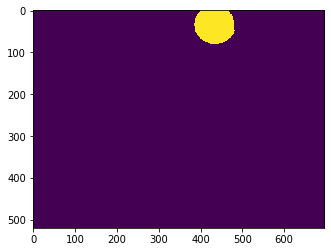

In [10]:
plt.imshow(label_img==4)

In [11]:
def openCV(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    kernel = np.ones((3,3),np.uint8)
    filled = ndi.binary_fill_holes(thresh)
    filled = np.uint8(filled)

    # sure background area
    sure_bg = cv2.dilate(filled,kernel,iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(filled,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown==1] = 0
    ws_img = cv2.watershed(img, markers)
    ws_img[ws_img==-1] = 0
    label_img = measure.label(ws_img)
    plt.imshow(label_img)

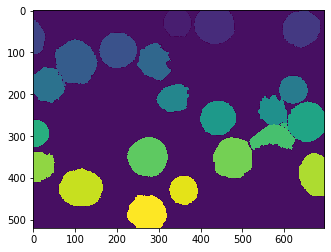

In [12]:
openCV('Malaria_5Slices_sl1_ch1_p1_t1.tif')

[[[[0]]

  [[0]]

  [[0]]

  ...

  [[0]]

  [[0]]

  [[0]]]


 [[[0]]

  [[0]]

  [[0]]

  ...

  [[0]]

  [[0]]

  [[0]]]


 [[[0]]

  [[0]]

  [[0]]

  ...

  [[0]]

  [[0]]

  [[0]]]


 ...


 [[[0]]

  [[0]]

  [[0]]

  ...

  [[0]]

  [[0]]

  [[0]]]


 [[[0]]

  [[0]]

  [[0]]

  ...

  [[0]]

  [[0]]

  [[0]]]


 [[[0]]

  [[0]]

  [[0]]

  ...

  [[0]]

  [[0]]

  [[0]]]]
[27.371909241837297, 3.395318206972884, 0.28682969442274187, 0.0011134606120390817, 0.03336855723640268, 0.9832191339794774]


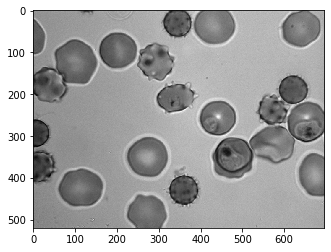

In [15]:
for cell in measure.regionprops(label_img):
    ratio = (cell.perimeter**2)/(4*math.pi*cell.area)
cm = feature.greycomatrix(gray, [1], [0])
print(cm)
    
contrast = feature.greycoprops(cm)
dissimilarity = feature.greycoprops(cm, 'dissimilarity')
homogeneity = feature.greycoprops(cm, 'homogeneity')
ASM = feature.greycoprops(cm, 'ASM')
energy = feature.greycoprops(cm, 'energy')
correlation = feature.greycoprops(cm, 'correlation')
plt.imshow(gray, cmap='gray')

print([contrast[0][0], dissimilarity[0][0], homogeneity[0][0], 
       ASM[0][0], energy[0][0], correlation[0][0]])

[152.46008403361344, 3.3998599439775905, 0.6490790496050217, 0.31789308860799226, 0.563820085317996, 0.9636968995856846]


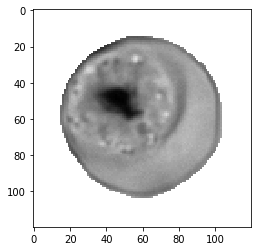

In [43]:
#label_img = openCV('/Users/reganlamoureux/Downloads/rbc_00514.tif')
img = cv2.imread('/Users/reganlamoureux/schizont/rbc_05856.tif')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray==(label_img==2)
label_img = openCV(gray)
print(label_img)

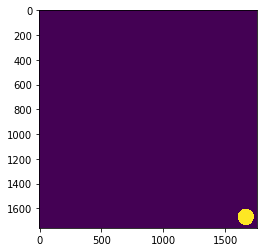

In [47]:
plt.imshow(label_img==95)

In [ ]:
f,ax = plt.subplots(2)
f.set_size_inches(16,8)
ax[0].imshow(ws_img==7)
ax[1].imshow(img)

In [ ]:
f,ax = plt.subplots(2,3)
f.set_size_inches(16, 8)
ax[0,0].imshow(img, cmap='gray')
ax[0,1].imshow(thresh)
ax[0,2].imshow(sure_bg, cmap='gray')
ax[1,0].imshow(sure_fg, cmap='gray')
ax[1,1].imshow(markers_1, cmap='gray')
ax[1,2].imshow(ws_img)


(520, 696)


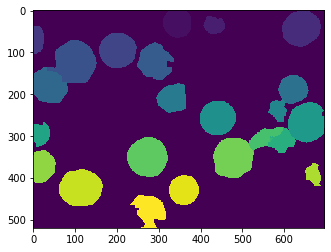

In [18]:
from skimage import segmentation
import skimage.filters as flt
from skimage import measure
import skimage.morphology as morph

img = cv2.imread('Malaria_5Slices_sl1_ch1_p1_t1.tif')

img_gs = rgb2gray(img)
thr = flt.threshold_otsu(img_gs)
thresh_img = img_gs < thr

kernel = np.ones((3,3),np.uint8)
filled = ndi.binary_fill_holes(thresh_img)
filled = np.uint8(filled)


# sure background area
sure_bg = morph.dilation(filled, kernel)

# Finding sure foreground area
dist_transform = ndi.distance_transform_edt(filled)
dist_thr = int(0.5*dist_transform.max())
sure_fg = dist_transform > dist_thr # cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
print(sure_fg.shape)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = sure_bg - sure_fg

markers, num_labels = measure.label(sure_fg, background=0, return_num=True)
markers = markers + 1
markers[unknown==1] = 0
# smooth img_gs to remove noise
img_smth = flt.gaussian(img_gs, sigma=5)
# edgemap
edg_img = flt.sobel(img_smth)
ws_img = morph.watershed(edg_img, markers)
label_img = measure.label(ws_img)
boundary = segmentation.mark_boundaries(img_gs, label_img)

#img_gs[ws_img == -1] = [255,0,0]
plt.imshow(ws_img)


In [ ]:
plt.imshow(label_img)

In [ ]:
f,ax = plt.subplots(2,3)
f.set_size_inches(16, 8)
ax[0,0].imshow(img_gs, cmap='gray')
ax[0,1].imshow(thresh_img)
ax[0,2].imshow(sure_bg, cmap='gray')
ax[1,0].imshow(sure_fg, cmap='gray')
ax[1,1].imshow(label_img, cmap='gray')
ax[1,2].imshow(ws_img)

In [ ]:
    counter = 0
    meanX = 0
    meanY = 0
    sigmaX = 0
    sigmaY = 0
    pTotal = 0

    for i in range(0, len(cm)):
        piX = 0
        piY = 0
        iLine = 0
        jLine = 0
        for j in range(0, len(cm)):
            piX += cm[i,j]
            piY += cm[j,i]
            pTotal += cm[i,j]
            meanY += j*piX
            counter += 1
        iLine += i * piX
        jLine += j * piY
        meanX += i * piX
        sigmaX += (piX-iLine)**2
        sigmaY += (piY-jLine)**2
    mean = pTotal/counter
    
    asm = 0
    contrast = 0
    idm = 0
    entr = 0
    corr = 0
    variance = 0
    sumAv = 0
    diffEntr = 0
    
    for i in range(0, len(cm)):
        for j in range(0, len(cm)):
            p = cm[i,j]
            asm += p**2
            corr += ((i*j)*p-(meanX*meanY)/(math.sqrt(sigmaX)*math.sqrt(sigmaY)))
            variance += ((i-mean)**2)*p
            if i!=j:
                contrast += p*(i-j)**2
                idm += (1/(1+((i-j)**2)))*p
            if cm[i,j]!=0:
                entr += -(p*math.log(p))
                diffEntr += 
    return [asm, contrast, idm, entr, corr, variance]